# PMFs and PDFs

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1cibmgg/q_comparison_between_pmf_and_pdf_on_a_plot/).

> I met a basic problem in pdf and pmf. I perform a grid approximation on bayesian problem. After normalizing the vector, I got a discretized pmf. Then I want to draw pmf and pdf on a plot to check if they are similar distribution. However, the pmf doesn’t resemble the pdf at all. The instruction told me that I need to sample from my pmf then draw a histogram with density for comparison. It really works, but why can't I directly compare them?

In *Think Bayes* I used this kind of discrete approximation in almost every chapter, so this issue came up a lot! There are at least two good solutions:

* Normalize the PDF and PMF so they are on the same scale, or

* Use CDFs.

I'll demonstrate both.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/pmf_and_pdf.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Answer


As an example, I'll solve an exercise from Chapter xxx of Think Bayes:

> In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33.
>
> Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

To represent the prior distribution, I'll use a beta distribution with parameters I chose to be consistent with the assumption that most batting averages are between .230 and .300.

In [3]:
from scipy.stats import beta

a, b = 40, 110
beta_prior = beta(a, b)
beta_prior.mean(), beta_prior.ppf([0.15, 0.85])

(0.26666666666666666, array([0.22937673, 0.30411982]))

Here's what the PDF of this distribution looks like.

In [4]:
qs = np.linspace(0, 1, 101)
ps = beta_prior.pdf(qs)

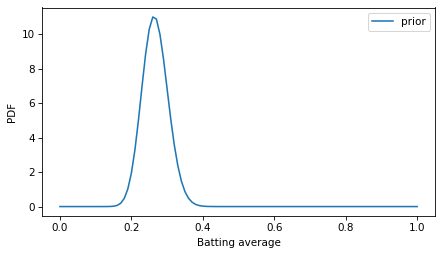

In [5]:
plt.plot(qs, ps, label='prior')
decorate(xlabel='Batting average', ylabel='PDF')

Unlike probability masses, probability densities can exceed 1.
But the area under the curve should be 1, which we can check using `trapz`, which is a NumPy function that computes numerical integrals using the trapezoid rule.

In [6]:
area = np.trapz(ps, qs)
area

0.9999999999999999

Within floating-point error, the area under the PDF is 1.
To do the Bayesian update, I'll put these values in a `Pmf` object and normalize it so the sum of the probability masses is 1.

In [7]:
from empiricaldist import Pmf

pmf_prior = Pmf(ps, qs, copy=True)
pmf_prior.normalize()

100.0

Now we can use `binom` to compute the probability of the data for each possible batting average in `qs`.

In [8]:
from scipy.stats import binom

k = 3
n = 3
likelihood = binom.pmf(k, n, qs)

To compute the posterior distribution, we multiply the prior by the likelihood and normalize again so the sum of the posterior `Pmf` is 1.

In [9]:
pmf_posterior = pmf_prior * likelihood
pmf_posterior.normalize()

0.020006971070059262

The result is a discrete approximation of the actual posterior distribution -- so let's see how close it is.

Because the beta distribution is the conjugate prior of the binomial likelihood function, the posterior is also a beta distribution, with parameters updated to reflect the data: 3 successes and 0 failures.

In [10]:
beta_posterior = beta(a+3, b)

Here's what this theoretical posterior distribution looks like compared to our numerical approximation.

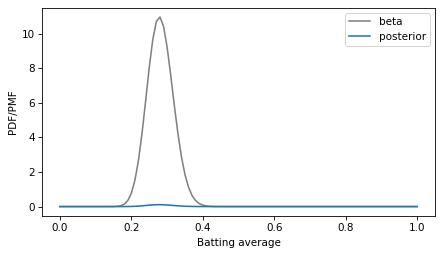

In [11]:
ps = beta_posterior.pdf(qs)
plt.plot(qs, ps, color='gray', label='beta')
pmf_posterior.plot(label='posterior')

decorate(xlabel='Batting average', ylabel='PDF/PMF')

Oops! Something has gone wrong. I assume this is what OP meant by "the pmf doesn't resemble the pdf at all".

The problem is that the PMF is normalized so the total of the probability masses is 1, and the PDF is normalized so the area under the curve is 1.
They are not on the same scale, so the y-axis in this figure is different for the two curves.

To fix the problem, we can find the area under the PMF.

In [12]:
area = np.trapz(pmf_posterior.ps, pmf_posterior.qs)
area

0.01

And divide through to create a discrete approximation of the posterior PDF.

In [13]:
pdf_posterior = pmf_posterior / area

Now we can compare density to density.

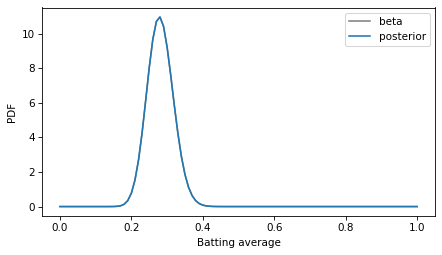

In [14]:
ps = beta_posterior.pdf(qs)
plt.plot(qs, ps, color='gray', label='beta')
pdf_posterior.plot(label='posterior')

decorate(xlabel='Batting average', ylabel='PDF')

The curves are visually indistinguishable, and the numerical differences are small. 

In [15]:
diff = ps - pdf_posterior.ps
np.max(np.abs(diff))

4.618527782440651e-14

As an aside, note that the posterior and prior distributions are not very different.
The prior mean is 0.267 and the posterior mean is 0.281.
If a rookie goes 3 for 3 in their first game, that's a good start, but it doesn't mean they are the next Ted Williams.

In [16]:
pmf_prior.mean(), pmf_posterior.mean()

(0.26666666666666666, 0.28104575163398704)

As an alternative to comparing PDFs, we could convert the PMF to a CDF, which contains the cumulative sum of the probability masses.

In [17]:
cdf_posterior = pmf_posterior.make_cdf()

And compare to the mathematical CDF of the beta distribution.

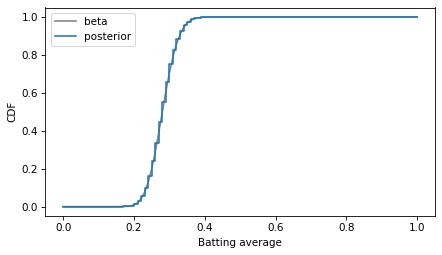

In [18]:
ps = beta_posterior.cdf(qs)
plt.plot(qs, ps, color='gray', label='beta')

cdf_posterior.step(label='posterior')

decorate(xlabel='Batting average', ylabel='CDF')

In this example, I plotted the discrete approximation of the CDF as a step function -- which is technically what it is -- to highlight how it overlaps with the beta distribution.

## Discussion

Probability density is hard to define -- the best I can do is usually, "It's something that you can integrate to get a probability mass".
And when you work with probability densities computationally, you often have to discretize them, which can add another layer of confusion.

One way to distinguish PMFs and PDFs is the remember that PMFs are normalized so the probability masses add up to 1, and PDFs are normalized so the area under the curve is 1.
In general, you can't plot PMFs and PDFs on the same axes because they are not in the same units.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)